In [23]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('../Dataset/train.csv', engine='python', encoding='utf-8')
train_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE


In [4]:
valid_data = pd.read_csv('../Dataset/valid.csv', engine='python', encoding='utf-8')
valid_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [5]:
data = pd.concat([train_data, valid_data])
data = data.drop(columns = ['Id', 'CreationDate'])
data

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ
...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE


In [6]:
data['Tags'].value_counts()

<python>                                                 1068
<java>                                                   1013
<javascript>                                              879
<c#>                                                      672
<c++>                                                     668
                                                         ... 
<python><python-3.x><package><installation><anaconda>       1
<css><button><social><display>                              1
<node.js><typescript><typescript2.0>                        1
<jquery><html><asp.net-mvc><razor>                          1
<c++><overloading><return-type>                             1
Name: Tags, Length: 33224, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   60000 non-null  object
 1   Body    60000 non-null  object
 2   Tags    60000 non-null  object
 3   Y       60000 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


[Text(0, 0, '20000'), Text(0, 0, '20000'), Text(0, 0, '20000')]

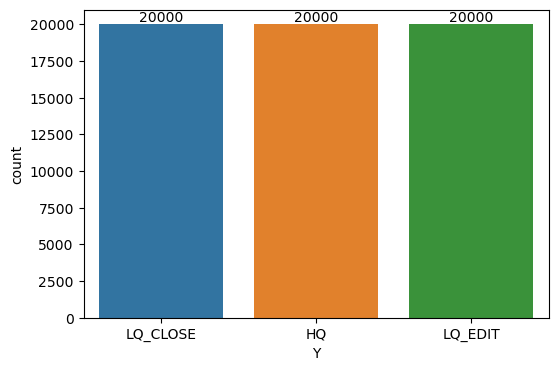

In [8]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [9]:
# CLEANR = re.compile('<.*?>') 
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, ' ', raw_html)
    return cleantext

def clean_text(text):
    text = text.lower()
    text = text.replace("[^a-zA-Z#]", " ")
    text = text.replace('http\S+|www.\S+|.com\S+', ' ')
    text = re.sub(CLEANR, ' ', text)
    text = re.sub("#+"," ", text)
    text = re.sub("@[\w]*"," ", text)
    text = re.sub("[^a-z\s]"," ", text)
    text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [10]:
data['clean_text'] = data['Body'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) > 4])) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))
data

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,clean_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE,familiar repeating tasks timer timertask print...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ,understand optionals designed immutable thread...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ,attempting overlay title image image darkened ...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ,question simple answer return compile return w...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ,custom floatingactionmenu implement scale anim...
...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE,controls theory controls align navbar start it...
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE,multiply integer double wrong result result de...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT,django contrib import admin django import impo...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE,controller server connected network searching ...


<Axes: xlabel='text_len'>

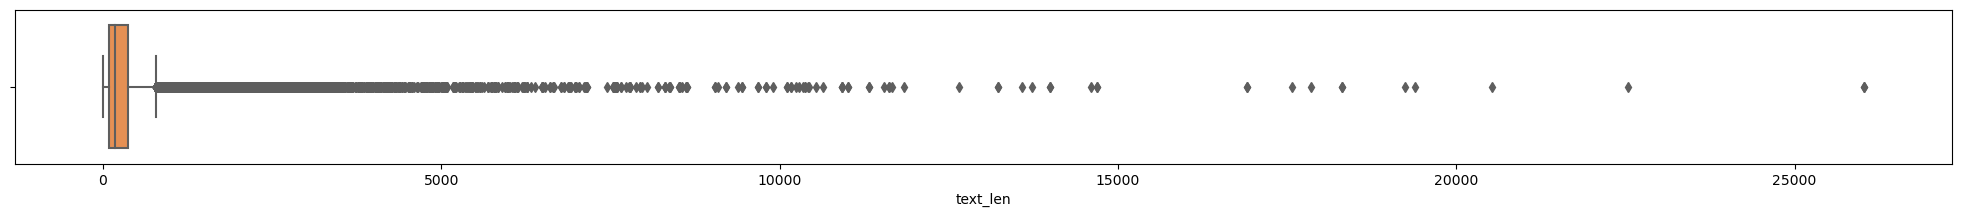

In [11]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [12]:
Q1 = data['text_len'].quantile(0.05)
Q3 = data['text_len'].quantile(0.95)
print(Q1)
print(Q3)

39.0
1164.0


<Axes: xlabel='text_len'>

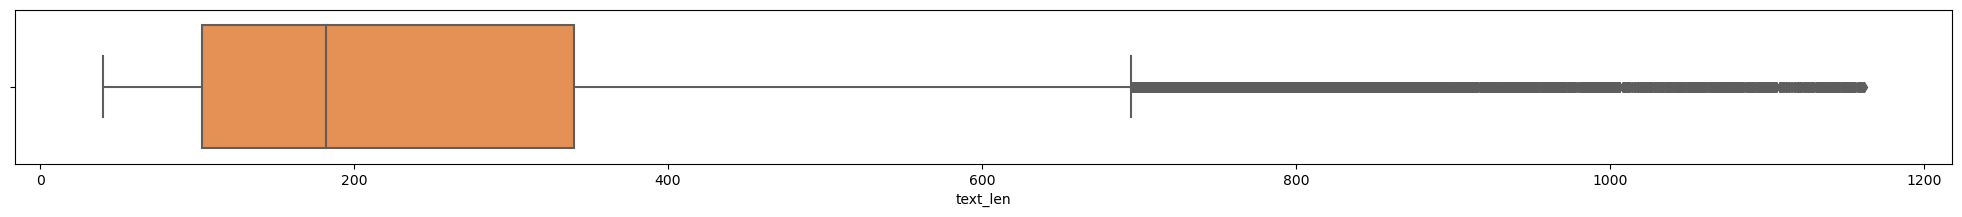

In [12]:
Q1 = data['text_len'].quantile(0.05)
Q3 = data['text_len'].quantile(0.95)
IQR = Q3 - Q1

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '17711'), Text(0, 0, '18316'), Text(0, 0, '17929')]

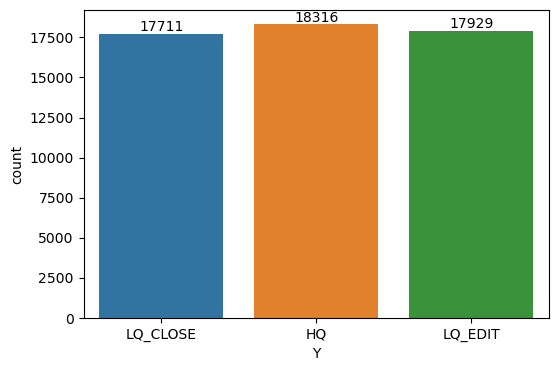

In [15]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [16]:
X = data['clean_text']
# Y = data['Y']
Y = pd.get_dummies(data['Y'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [17]:
vocab_size = 10000
embedding_dim = 64
max_length = 1200
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(len(word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np. array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np. array(y_test)

107691


In [20]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(3, activation='sigmoid'))
    # model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(128, 5, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling1D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv1D(64, 5, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling1D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv1D(32, 5, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling1D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv1D(16, 5, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling1D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(units=32))
    model.add(Dense(units=1))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    


# model = DNN_Model()
model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()

model.summary()

# model.compile(loss='mse', optimizer='adam', metrics=['binary_accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['categorical_accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1200, 64)          640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 1196, 128)         41088     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1196, 128)         0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 598, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 598, 128)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 598, 128)         512       
 hNormalization)                                      

In [22]:
num_epoch = 20
history = model.fit(training_padded, training_label, 
                    batch_size=64, epochs=num_epoch, 
                    validation_data=(testing_padded, testing_label))

Epoch 1/20
633/633 [==============================] - 30s 46ms/step - loss: 0.1999 - categorical_accuracy: 0.6581 - val_loss: 0.2326 - val_categorical_accuracy: 0.6042
Epoch 2/20
633/633 [==============================] - 29s 46ms/step - loss: 0.1975 - categorical_accuracy: 0.6644 - val_loss: 0.2176 - val_categorical_accuracy: 0.6003
Epoch 3/20
633/633 [==============================] - 29s 46ms/step - loss: 0.1960 - categorical_accuracy: 0.6668 - val_loss: 0.2693 - val_categorical_accuracy: 0.5054
Epoch 4/20
633/633 [==============================] - 29s 46ms/step - loss: 0.1939 - categorical_accuracy: 0.6712 - val_loss: 0.2189 - val_categorical_accuracy: 0.5939
Epoch 5/20
633/633 [==============================] - 29s 46ms/step - loss: 0.1964 - categorical_accuracy: 0.6752 - val_loss: 0.2481 - val_categorical_accuracy: 0.5652
Epoch 6/20
633/633 [==============================] - 29s 46ms/step - loss: 0.1940 - categorical_accuracy: 0.6764 - val_loss: 0.2177 - val_categorical_accuracy:

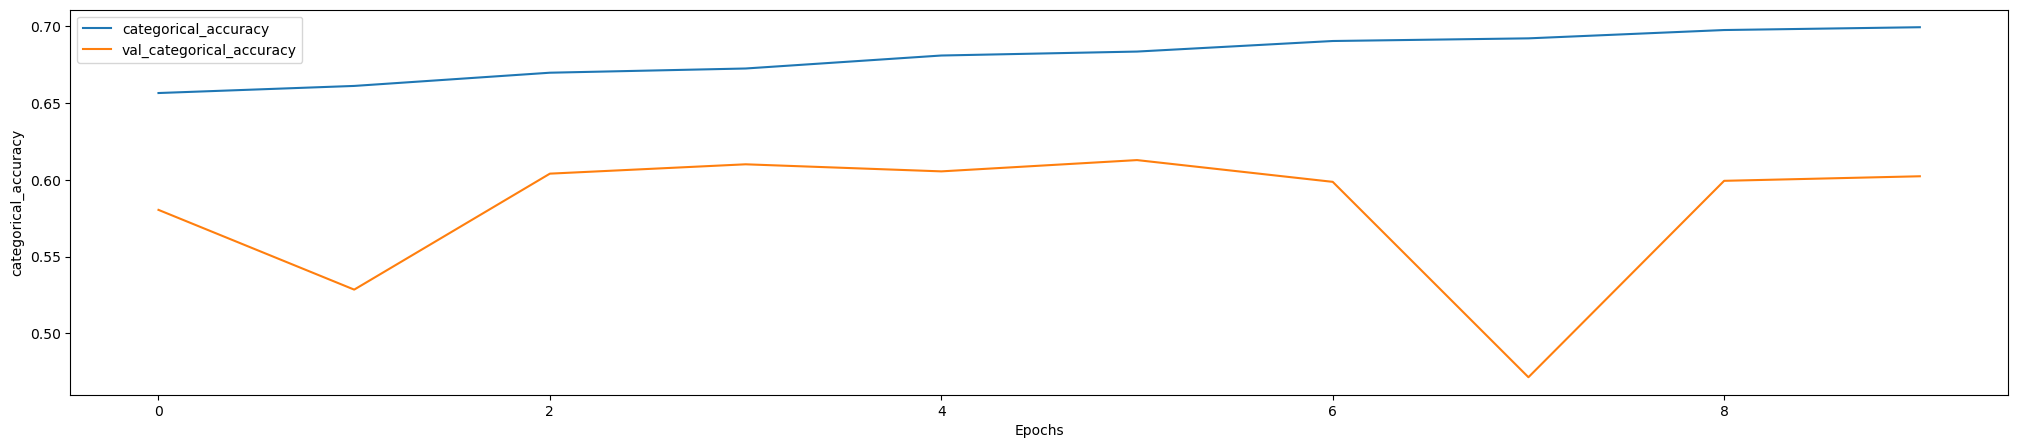

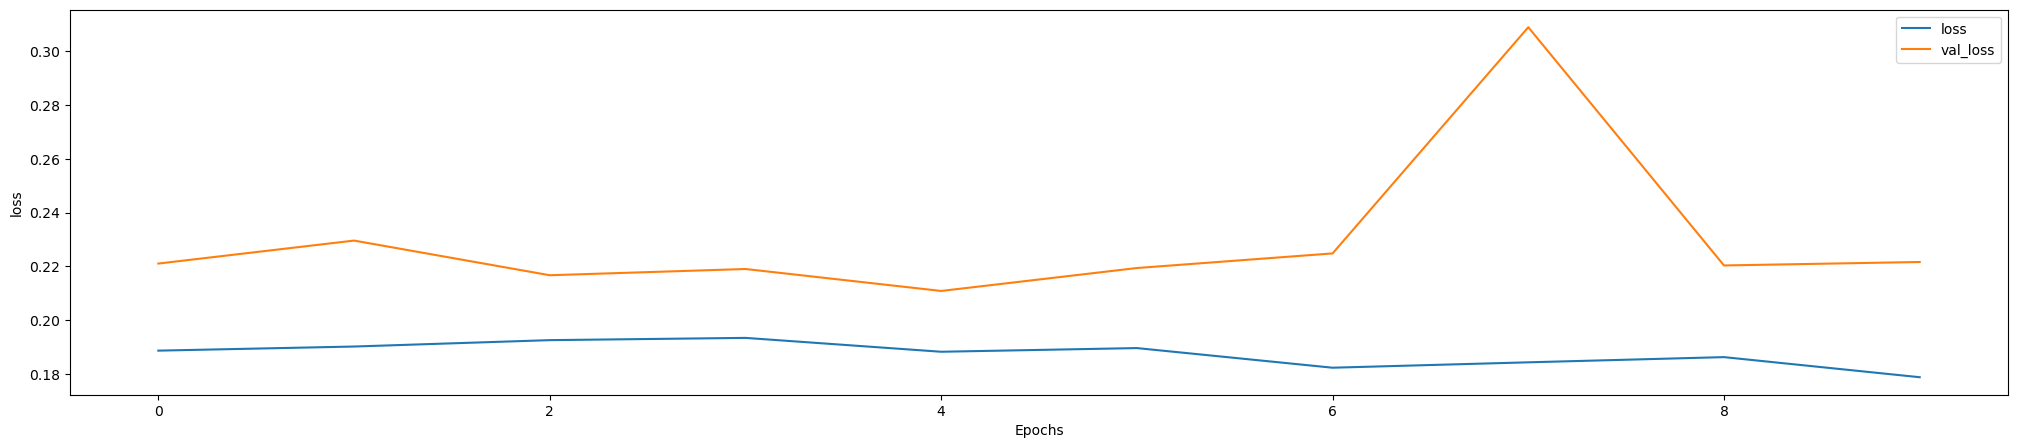

In [22]:
def plot_graphs(history, string):
    plt.subplots(figsize=(25, 5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "loss")

422/422 [==============================] - 3s 7ms/step


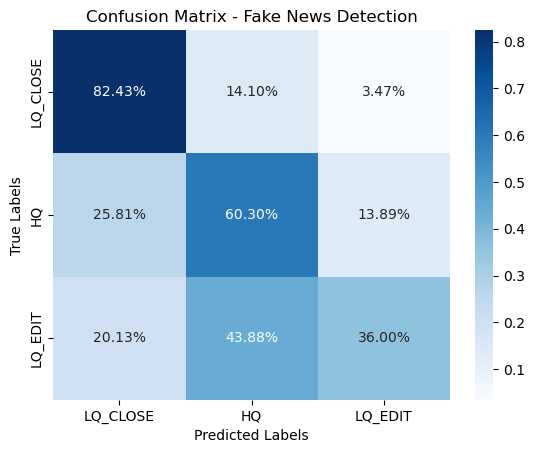

In [29]:
labels = ['LQ_CLOSE', 'HQ', 'LQ_EDIT']

y_pred = np.rint(model.predict(testing_padded))
# Build confusion matrix
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()